In [3]:
import convex as cx

In [4]:
import networkx as nx

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Building labels for graph
def get_labels_from_graph(graph):
    labels = dict()
    node_names = [n for n in graph.nodes()]
    for i, node in enumerate(node_names):
        position = node.find("-")
        if position >= 0:
            node_src = node
            node = node[:position]
            node_names[i] = node[:position]
            labels[node_src] = str(cx.wd.wikidata_id_to_label(node))
        else:
            labels[node] = str(cx.wd.wikidata_id_to_label(node))
    return labels

# Plotting the graph
def plot_graph(graph, name, title="Graph"):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    ax.set_title(str("answer: "+title), fontsize=10)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_size=50, node_color='yellow', font_size=10, font_weight='bold', with_labels=True, labels=get_labels_from_graph(graph))
    plt.tight_layout()
    plt.savefig(str(name)+".png", format="PNG")
    plt.show()
    
# Asking follow up questions in the conversation
def ask_following_question(graph, next_question, turn):
    print("Asking: ",str(next_question))
    answer, graph = cx.answer_follow_up_question(next_question, turn, graph, cx.hyperparameters, cx.number_of_frontier_nodes)
    print(answer)
    #sorted_answer = sorted(answer, key = lambda a: a['answer_score'], reverse=True)
    print("I think it is:", str(cx.wd.wikidata_id_to_label(answer[0]['answer'])))
    return graph, answer

In [5]:
questions = [ 
    "Which actor voiced the Unicorn in The Last Unicorn?",
    "And Alan Arkin was behind...?",
    "Who is the composer of the soundtrack?",
    "So who performed the songs?",
    "Genre of this band's music?",
    "By the way, who was the director?"
            ]

In [ ]:
# Breakdown of:
# def answer_conversation(questions, tagmeToken, hyperparameters, number_of_frontier_nodes):

# turn = 1
# result = answer_complete_question(questions[0], tagmeToken)
# graph = gp.expand_context_with_statements(None, [result['context']], qa=True)
# turn += 1
# graph = answer_follow_up_question(question, turn, graph, hyperparameters, number_of_frontier_nodes)

In [9]:
import time
import json
import requests

def tagme_get_all_entities(utterance, tagmeToken):
    request_successfull = False
    while not request_successfull:
        try:
            results = json.loads(requests.get('https://tagme.d4science.org/tagme/tag?lang=en&gcube-token=' + tagmeToken + '&text=' + utterance).content)
            request_successfull = True
        except:
            print("Error: Did you put your tagMe_token in the settings file?")
            print(utterance)
            time.sleep(5)
    entities = []
    for result in results["annotations"]:
        try:
            wikidata_ids = cx.wd.name_to_wikidata_ids(result['title'])
        except:
            continue
        for wikidata_id in wikidata_ids:
            entities.append({'title': result['title'], 'spot': result['spot'], 'link_probability': result['link_probability'], 'wikidata_id': wikidata_id})
    return entities

In [7]:
# remove all unnecessary words of the question to avoid noise in the similarity-computation
def shorten_question_for_predicate_similarity(question, entity_spot):
    # remove the spot of the entity
#    print(question)
    question = question.replace(entity_spot, "")
#    print(question)

    # remove symbols
    question = question.replace(',', '').replace('!', '').replace('?', '').replace('.', '').replace("'", '').replace('"', '').replace(':','').replace('’', '')

    # expand the question by whitespaces to be able to find the stopwords
    question = (" " + question + " ").lower()

    # remove stopwords
    for stopword in cx.string.stopwords:
        question = question.replace(" "+stopword+" ", " ")

    # replace w words, but still keep the information in the question
    question = question.replace(" where ", " location ")
    question = question.replace(" wheres ", " location ")
    question = question.replace(" when ", " date ")
    question = question.replace(" whens ", " date ")
    question = question.replace(" who ", " person ")
    question = question.replace(" whos ", " person ")
    question = question.replace(" why ", " cause ")
    question = question.replace(" whys ", " cause ")

    # wikidata does not give the accuracy of the date (year, month, ...)
    question = question.replace('year', 'date')

    # remove remaining s from plural or possesive expressions
    question = question.replace(' s ', ' ')

    # remove whitespaces
    while "  " in question:
        question = question.replace("  ", " ")
    return question#.strip()

#for entity in entities:
#    shortened_question = shorten_question_for_predicate_similarity(question, entity['spot'])

#entities
#entity
#shortened_question

# Breakdown of the first answer

In [12]:
from pprint import pprint

question = questions[0]
turn = 1
entities = tagme_get_all_entities(question, cx.tagmeToken) 
highest_matching_similarity = -1
for entity in entities:
    result = {}
    shortened_question = shorten_question_for_predicate_similarity(question, entity['spot'])
    statements = cx.wd.get_all_statements_of_entity(entity['wikidata_id'])
    matching_similarity = ""
    for statement in statements:
        # no identifier predicates
        if statement['predicate']['id'] in cx.identifier_predicates:
            continue
        predicate_label = cx.wd.wikidata_id_to_label(statement['predicate']['id'])
        matching_similarity = cx.spacy.similarity_word2vec(predicate_label, shortened_question) * entity['link_probability']
        if highest_matching_similarity == -1 or matching_similarity > highest_matching_similarity:
            answer = statement['entity']['id'] if statement['object']['id'] == entity['wikidata_id'] else statement['object']['id']
            context = {'entity': {'id': entity['wikidata_id']}, 'predicate': {'id': statement['predicate']['id']}, 'object': {'id': answer}}
            result = {'context': context, 'answers': [{'answer': answer, 'rank': 1}] }
            highest_matching_similarity = matching_similarity
        
        print("START")
        print(entity)
        print(statement)
        print(predicate_label)
        print(shortened_question)
        #print(entity['spot'])
        #print(entity['link_probability'])
        print(matching_similarity)
        print("END")
        
    print(matching_similarity, highest_matching_similarity)
    print(entity)
    print(shortened_question)
    
    #print(statements)
    pprint(result)


 -1
{'title': 'Actor', 'spot': 'actor', 'link_probability': 0.09532184898853302, 'wikidata_id': 'Q33999'}
 voiced unicorn last unicorn 
{}
 -1
{'title': 'Actor', 'spot': 'actor', 'link_probability': 0.09532184898853302, 'wikidata_id': 'Q10798782'}
 voiced unicorn last unicorn 
{}
START
{'title': 'Actor', 'spot': 'actor', 'link_probability': 0.09532184898853302, 'wikidata_id': 'Q15723603'}
{'entity': {'id': 'Q15723603'}, 'predicate': {'id': 'P106'}, 'object': {'id': 'Q33999'}, 'qualifiers': [{'qualifier_predicate': {'id': 'P136'}, 'qualifier_object': {'id': 'Q11635'}}]}
occupation
 voiced unicorn last unicorn 
0.009736321805878124
END
START
{'title': 'Actor', 'spot': 'actor', 'link_probability': 0.09532184898853302, 'wikidata_id': 'Q15723603'}
{'entity': {'id': 'Q15723603'}, 'predicate': {'id': 'P19'}, 'object': {'id': 'Q2563358'}, 'qualifiers': []}
place of birth
 voiced unicorn last unicorn 
0.030725656244235316
END
START
{'title': 'Actor', 'spot': 'actor', 'link_probability': 0.09532

In [26]:
question

'Which actor voiced the Unicorn in The Last Unicorn?'

In [45]:
from pprint import pprint
pprint(entities)

[{'link_probability': 0.09532184898853302,
  'spot': 'actor',
  'title': 'Actor',
  'wikidata_id': 'Q33999'},
 {'link_probability': 0.09532184898853302,
  'spot': 'actor',
  'title': 'Actor',
  'wikidata_id': 'Q10798782'},
 {'link_probability': 0.09532184898853302,
  'spot': 'actor',
  'title': 'Actor',
  'wikidata_id': 'Q15723603'},
 {'link_probability': 0.01868159882724285,
  'spot': 'voiced',
  'title': 'Voice acting',
  'wikidata_id': 'Q22920017'},
 {'link_probability': 0.01868159882724285,
  'spot': 'voiced',
  'title': 'Voice acting',
  'wikidata_id': 'Q7939496'},
 {'link_probability': 0.01868159882724285,
  'spot': 'voiced',
  'title': 'Voice acting',
  'wikidata_id': 'Q16154937'},
 {'link_probability': 0.888059675693512,
  'spot': 'Last Unicorn',
  'title': 'The Last Unicorn (film)',
  'wikidata_id': 'Q176198'},
 {'link_probability': 0.888059675693512,
  'spot': 'Last Unicorn',
  'title': 'The Last Unicorn (film)',
  'wikidata_id': 'Q967268'},
 {'link_probability': 0.8880596756

In [32]:
pprint(shortened_question)

'actor voiced unicorn'


# Breakdown of initial graph building

In [8]:
import networkx as nx
def expand_context_with_statements(context, statements, turn = 1, qa=False):
    if not context:
        context = nx.Graph()

    # print statements
    for statement in statements:
        # add the entity and object node
        if not statement['entity']['id'] in context:
            context.add_node(statement['entity']['id'], type='entity', turn=turn, qa=qa)
        if not statement['object']['id'] in context:
            context.add_node(statement['object']['id'], type='entity', turn=turn, qa=qa)

        # get current index of predicate used
        if not cx.gp.predicate_nodes.get(statement['predicate']['id']):
            # the predicate did not occur yet => index 0 and new entry
            cx.gp.predicate_nodes[statement['predicate']['id']] = 1
            predicate_index = 0
        else:
            # the predicate already occured => fetch the next index available and increase the saved one
            predicate_index = cx.gp.predicate_nodes[statement['predicate']['id']]
            cx.gp.predicate_nodes[statement['predicate']['id']] += 1

        # add the predicate node
        predicate_node_id = (statement['predicate']['id'] + "-" + str(predicate_index))
        context.add_node(predicate_node_id, type='predicate', turn=turn)

        # add the two edges (entity->predicate->object)
        context.add_edge(statement['entity']['id'], predicate_node_id)
        context.add_edge(predicate_node_id, statement['object']['id'])

        # if there were qualifiers occuring in the statement
        if statement.get('qualifiers'):
            for qualifier_statement in statement['qualifiers']:
                # add the qualifier_statment object
                if not qualifier_statement['qualifier_object']['id'] in context:
                    context.add_node(qualifier_statement['qualifier_object']['id'], type='entity', turn=turn, qa=qa)

                # get current index of qualifier_predicate used
                if not qualifier_predicate_nodes.get(qualifier_statement['qualifier_predicate']['id']):
                    # the qualifier_predicate did not occur yet => index 0 and new entry
                    qualifier_predicate_nodes[qualifier_statement['qualifier_predicate']['id']] = 1
                    predicate_index = 0
                else:
                    # the qualifier_predicate already occured => fetch the next index available and increase the saved one
                    predicate_index = qualifier_predicate_nodes[qualifier_statement['qualifier_predicate']['id']]
                    qualifier_predicate_nodes[qualifier_statement['qualifier_predicate']['id']] += 1

                # add the qualifier_predicate
                qualifier_predicate_node_id = qualifier_statement['qualifier_predicate']['id'] + "-" + str(predicate_index)
                context.add_node(qualifier_predicate_node_id, type='qualifier_predicate', turn=turn)

                # add the two edges (qualifier_entity->qualifier_predicate->qualifier_object)
                context.add_edge(predicate_node_id, qualifier_predicate_node_id)
                context.add_edge(qualifier_predicate_node_id, qualifier_statement['qualifier_object']['id'])
    return context

In [10]:
result

{}

In [9]:
graph = expand_context_with_statements(None, [result['context']], qa=True)

KeyError: 'context'

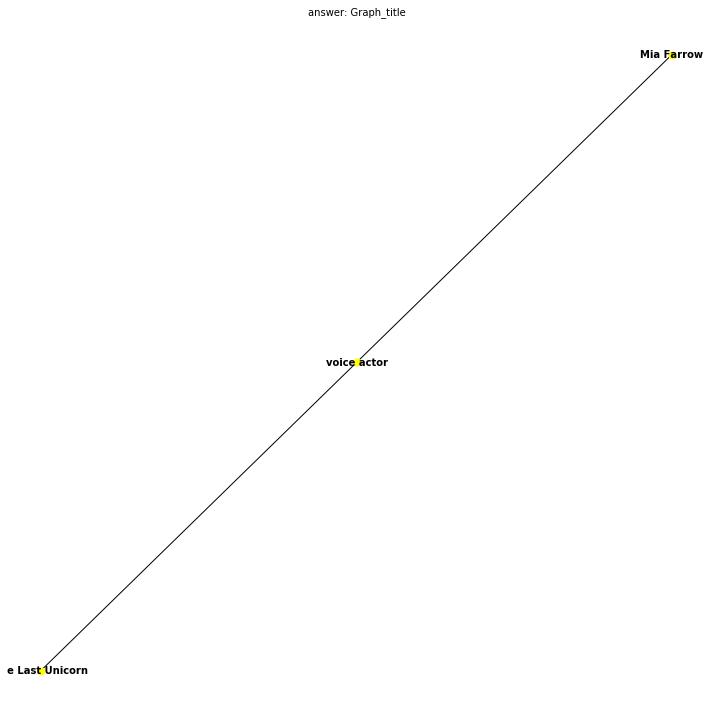

In [75]:
plot_graph(graph, "file_name_graph", "Graph_title")